<a href="https://colab.research.google.com/github/arguntolga/ts_jupyter/blob/main/abma_sheets4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Toplam Hisse:  102


[*********************100%%**********************]  102 of 102 completed


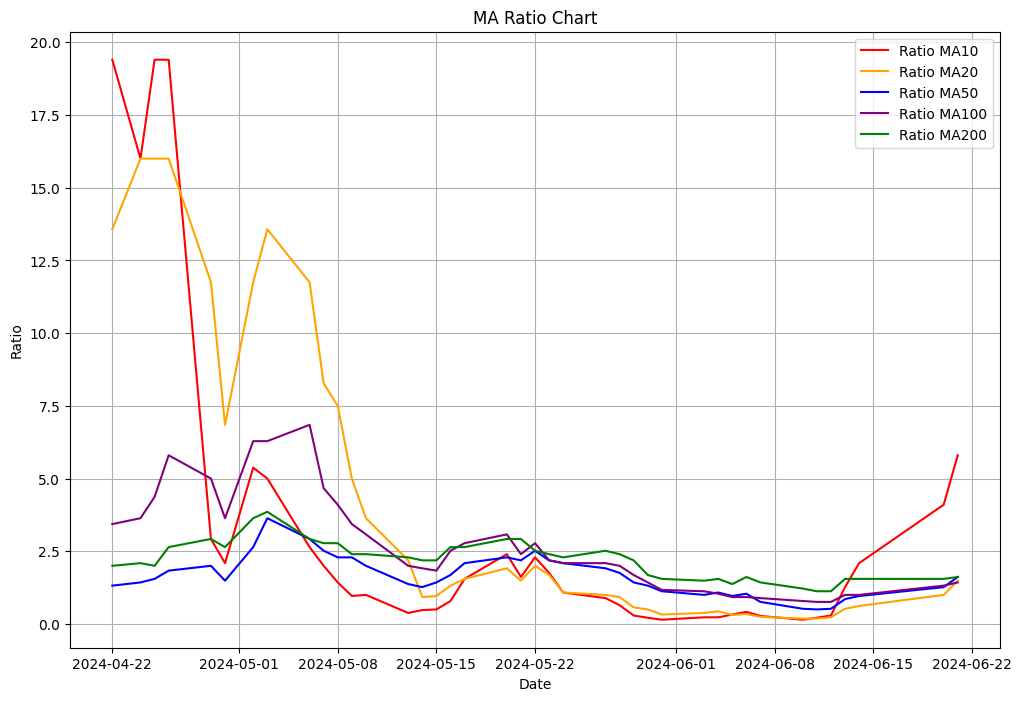

Sheet 'Above_Below_MA(Daily)' deleted successfully.
Sheet 'Above_Below_MA(Daily)' created successfully.


,Above MA10,Below MA10,Ratio MA10,Above MA20,Below MA20,Ratio MA20,Above MA50,Below MA50,Ratio MA50,Above MA100,Below MA100,Ratio MA100,Above MA200,Below MA200,Ratio MA200
2024-06-21,87,15,5.800000,61,41,1.487805,63,39,1.615385,60,42,1.428571,63,39,1.615385
2024-06-20,82,20,4.100000,51,51,1.000000,57,45,1.266667,58,44,1.318182,62,40,1.550000
2024-06-14,69,33,2.090909,39,63,0.619048,50,52,0.961538,51,51,1.000000,62,40,1.550000
2024-06-13,57,45,1.266667,35,67,0.522388,47,55,0.854545,51,51,1.000000,62,40,1.550000
2024-06-12,23,79,0.291139,19,83,0.228916,35,67,0.522388,44,58,0.758621,54,48,1.125000
2024-06-11,18,84,0.214286,16,86,0.186047,34,68,0.500000,44,58,0.758621,54,48,1.125000
2024-06-10,13,89,0.146067,16,86,0.186047,35,67,0.522388,45,57,0.789474,56,46,1.217391
2024-06-07,22,80,0.275000,20,82,0.243902,44,58,0.758621,48,54,0.888889,60,42,1.428571
2024-06-06,30,72,0.416667,26,76,0.342105,52,50,1.040000,49,53,0.924528,63,39,1.615385
2024-06-05,25,77,0.324675,24,78,0.307692,50,52,0.961538,49,53,0.924528,59,43,1.372093


In [8]:
!pip install --upgrade -q gspread
!pip install gspread_formatting

import yfinance as yf
import pandas as pd
import pandas.api.types as pdtypes
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import gspread
from google.colab import auth
from google.auth import default
import gspread_formatting
from gspread_formatting import *
from gspread_formatting import ConditionalFormatRule
from gspread_formatting.models import CellFormat, Color, TextFormat, NumberFormat
from gspread_formatting.functions import format_cell_ranges, set_frozen
from gspread_formatting import set_column_width , set_column_widths
from matplotlib import colors
from matplotlib import pyplot
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Define your two stock tickers
#stock_list = ["EREGL.IS", "FROTO.IS", "THYAO.IS", "TTRAK.IS", "MIATK.IS"]
stock_list = [
   "AGROT.IS","AKBNK.IS","AKSA.IS","AKSEN.IS","ALARK.IS","ALFAS.IS","ALGYO.IS",
   "ALKA.IS","ALKIM.IS","ANGEN.IS","ARCLK.IS","ARDYZ.IS","ASELS.IS","ASTOR.IS",
   "BIMAS.IS","BNTAS.IS","BOBET.IS","BRISA.IS","BRYAT.IS","CIMSA.IS","CLEBI.IS",
   "CVKMD.IS","CWENE.IS","DOAS.IS","DOHOL.IS","EGEEN.IS","EKGYO.IS","ELITE.IS",
   "ENJSA.IS","ENKAI.IS","ERBOS.IS","EREGL.IS","EUPWR.IS","FROTO.IS","GARAN.IS",
   "GESAN.IS","GUBRF.IS","GWIND.IS","HALKB.IS","HEKTS.IS","HKTM.IS","HUNER.IS",
   "IPEKE.IS","ISCTR.IS","ISGYO.IS","ISMEN.IS","ISYAT.IS","JANTS.IS","KAREL.IS",
   "KARSN.IS","KCHOL.IS","KLKIM.IS","KLSER.IS","KMPUR.IS","KONTR.IS","KONYA.IS",
   "KORDS.IS","KOZAA.IS","KOZAL.IS","KRDMD.IS","LOGO.IS","MAVI.IS","MGROS.IS",
   "MIATK.IS","ODAS.IS","ORGE.IS","OTKAR.IS","OYAKC.IS","PARSN.IS","PETKM.IS",
   "PGSUS.IS","PNLSN.IS","POLTK.IS","SAHOL.IS","SASA.IS","SAYAS.IS","SISE.IS",
   "SMRTG.IS","SOKM.IS","SUWEN.IS","TABGD.IS","TAVHL.IS","TCELL.IS","TEZOL.IS",
   "THYAO.IS","TKFEN.IS","TKNSA.IS","TOASO.IS","TTKOM.IS","TTRAK.IS","TUKAS.IS",
   "TUPRS.IS","ULKER.IS","ULUUN.IS","VESBE.IS","VESTL.IS","YAPRK.IS","YATAS.IS",
   "YEOTK.IS","YKBNK.IS","YUNSA.IS","YYLGD.IS"

]

print("Toplam Hisse: ", len(stock_list))

# Set start and end dates
start_date = "2023-05-04"
end_date = "2024-12-31"

# Download data using yfinance
data = yf.download(stock_list, start=start_date, end=end_date)["Adj Close"]
data = data.fillna(0)
data.index = data.index.date
#display(data)

def calculate_moving_averages(stock_list, data, window_sizes):
  for stock in stock_list:
    for window in window_sizes:
      data[stock + '_MA_' + str(window)] = data[stock].rolling(window=window).mean()
  return data

def calculate_above_below_ma(stock_list, data, window_sizes):
  above_below_counts = {}
  for date in data.index:
    daily_counts = {}
    for window in window_sizes:
      above_count = 0
      for stock in stock_list:
        ma_col = f"{stock}_MA_{window}"
        above_count += (data.loc[date, stock] > data.loc[date, ma_col])
      below_count = len(stock_list) - above_count
      daily_counts["Above MA" + str(window)] = above_count
      daily_counts["Below MA" + str(window)] = below_count
      daily_counts["Ratio MA" + str(window)] = above_count / max(1,below_count)
    above_below_counts[date] = daily_counts
  return pd.DataFrame(above_below_counts).transpose()


def calculate_super_stock(stock_list, data, window_sizes):
  super_stock = 0
  super_stock_df = pd.DataFrame(index=data.index, columns=stock_list)
  for date in data.index:
    for stock in stock_list:
      super_stock_level = 0
      if data.loc[date, stock] > data.loc[date, f"{stock}_MA_{window_sizes[0]}"]:
          super_stock_level += 1
      for window_idx in range(len(window_sizes) - 1):
        current_ma_col = f"{stock}_MA_{window_sizes[window_idx]}"
        next_ma_col = f"{stock}_MA_{window_sizes[window_idx + 1]}"
        if data.loc[date, current_ma_col] > data.loc[date, next_ma_col]:
          super_stock_level += 1
      super_stock_df.loc[date, stock] = int(super_stock_level)
  return super_stock_df


# Define window sizes for moving averages
window_sizes = [10, 20, 50, 100, 200]

# Apply the moving average calculation
data_with_ma = calculate_moving_averages(stock_list, data.copy(), window_sizes)
data_with_ma = data_with_ma.fillna(0)
#display(data_with_ma)

def drop_oldest_rows(data, n_rows_to_drop):
  # Sort by index (assuming it's a date index)
  data_sorted = data.sort_index()
  # Select and drop the oldest N rows using iloc (integer location based indexing)
  data_dropped = data_sorted.iloc[n_rows_to_drop:]
  return data_dropped

data_dropped_ma = drop_oldest_rows(data_with_ma.copy(), 200)

# Calculate above/below MA counts
above_below_data = calculate_above_below_ma(stock_list, data_dropped_ma.copy(), window_sizes)
#print(above_below_data)

def green_red(value):
    if value < 1:
        return 'color: red; font-weight: bold'
    elif value > 2:
        return 'color: green; font-weight: bold'
    else:
        return None

above_below_reversed = above_below_data.iloc[::-1]
#above_below_reversed.style.applymap(green_red)

def convert_to_int_if_zero_fraction(df):
  # Select numeric columns only (avoid errors with non-numeric data)
  numeric_cols = df.select_dtypes(include=[np.number])
  for col in numeric_cols:
    # Apply conversion function to the selected numeric column
    df[col] = df[col].apply(lambda x: int(x) if isinstance(x, (int, float)) and x % 1 == 0 else x)
  return df

# Apply conversion to all numeric columns
above_below_reversed = convert_to_int_if_zero_fraction(above_below_reversed.copy())  # Operate on a copy to avoid modifying original data

# Assuming 'Date' is the index (set as index if needed: df.set_index('Date'))
last_n_data = above_below_reversed.iloc[:40]

# Define color dictionary for different window sizes
color_dict = {
    'Ratio MA10': 'red',
    'Ratio MA20': 'orange',
    'Ratio MA50': 'blue',
    'Ratio MA100': 'purple',
    'Ratio MA200': 'green'
}

# Plot lines with colors from the dictionary
last_n_data.plot.line(y=color_dict.keys(), figsize=(12, 8), color=color_dict.values())
 # Adjust figsize for customization
plt.title("MA Ratio Chart")
plt.xlabel("Date")
plt.ylabel("Ratio")
plt.grid(True)
plt.show()


auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open the spreadsheet
spreadsheet_name = 'super_stock1'
spreadsheet = gc.open(spreadsheet_name)

def delete_and_create_sheet(spreadsheet, old_sheet_name, new_sheet_name, number_of_columns):
  # Check if there are more than one sheet before deleting
  if len(spreadsheet.worksheets()) > 1:
    # Delete the existing sheet (if provided)
    if old_sheet_name:
      try:
        worksheet = spreadsheet.worksheet(old_sheet_name)
        spreadsheet.del_worksheet(worksheet)
        print(f"Sheet '{old_sheet_name}' deleted successfully.")
      except gspread.SpreadsheetNotFound:
        print(f"Sheet '{old_sheet_name}' not found. Skipping deletion.")
  else:
    print("Cannot delete the only sheet in the document.")

  # Create a new sheet, specifying number of rows and columns
  new_worksheet = spreadsheet.add_worksheet(title=new_sheet_name, rows=500, cols=number_of_columns) # Added rows and cols
  print(f"Sheet '{new_sheet_name}' created successfully.")

old_sheet_name = 'Above_Below_MA(Daily)'
new_sheet_name = 'Above_Below_MA(Daily)'

number_of_columns = len(last_n_data.columns)

delete_and_create_sheet(spreadsheet, old_sheet_name, new_sheet_name, number_of_columns)


#worksheet = gc.open("super_stock1")
#sheet1 = worksheet.sheet1
sheet1 = spreadsheet.worksheet(new_sheet_name)

sheet1.update_title("Above_Below_MA(Daily)")

def _to_string(df: pd.DataFrame, *cols) -> pd.DataFrame:
    for col in cols:
        if col in df.columns:
            df[col] = df[col].astype(str)
    return df

last_n_data_no_dated = last_n_data

last_n_data = last_n_data.reset_index()
last_n_data = last_n_data.rename(columns={'index': 'Date'})
last_n_data = _to_string(last_n_data, "Date")

sheet1.update([last_n_data.columns.values.tolist()] + last_n_data.fillna(-1).values.tolist())

fmt = CellFormat(
    backgroundColor=Color(red=0.2, green=0.2, blue=0.2, alpha=1),
    textFormat=TextFormat(
        foregroundColor=Color(1, 1, 1),
        fontFamily="Merriweather",
        fontSize=10,
        bold=True
    ),
    horizontalAlignment="CENTER",
)

fmt2 = CellFormat(horizontalAlignment="CENTER")

format_cell_ranges(sheet1, [("A1:ZZ1", fmt), ("A2:ZZ500", fmt2)])
set_frozen(sheet1, rows=1, cols=1)
set_column_widths(sheet1, [('A', 76), ('B:EZ', 106)])


def index_to_spreadsheet_column(column_int, start_index=0):
  # https://stackoverflow.com/a/23862195/171847
  letter = ''
  while column_int > 25 + start_index:
      letter += chr(65 + int((column_int-start_index)/26) - 1)
      column_int = column_int - (int((column_int-start_index)/26))*26
  letter += chr(65 - start_index + (int(column_int)))
  return letter


# https://scipy-cookbook.readthedocs.io/items/Matplotlib_ColormapTransformations.html
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)



formats = []
for col_index in range(1, len(last_n_data.columns)):
  col_name = last_n_data.columns[col_index]
  col = last_n_data.iloc[:, col_index]

  idx = 2  # Assuming row index starts from 2

  if col_name.startswith("Ratio"):
    for value in col:
      cell_id = f"{index_to_spreadsheet_column(col_index)}{idx}"
      if value > 2:
        # Use RGB color values for dark green font (bold)
        color = {
            "red": 0.0,
            "green": 0.5,  # Darker green (adjust as needed)
            "blue": 0.0
        }
        background_color = {
            "red": 0.92,
            "green": 1.0,
            "blue": 0.92
        }
        bold = True
      elif value < 1:
        color = {
            "red": 1.0,  # Red
            "green": 0.0,
            "blue": 0.0
        }
        background_color = {
            "red": 1.0,
            "green": 0.92,
            "blue": 0.92
        }
        bold = True
      else:
        color = None
        bold = False  # No bold for other values (optional)

      if color:
        formats.append({
            "range": f"{cell_id}:{cell_id}",
            "format": {
                "textFormat": {
                    "foregroundColor": color,
                    "bold": bold
                },
                "backgroundColor": background_color,
                "numberFormat": {
                    "type": "NUMBER",  # Specify the number format type as 'NUMBER'
                    "pattern": "#,##0.00"  # Custom pattern for display
                }
            }
        })
      else:
        formats.append({
            "range": f"{cell_id}:{cell_id}",
            "format": {
                "numberFormat": {
                    "type": "NUMBER",  # Specify the number format type as 'NUMBER'
                    "pattern": "#,##0.00"  # Custom pattern for display
                }
            }
        })

      idx += 1

batch_format_response = sheet1.batch_format(formats)



def ratio_subset(window_sizes):
   ratio_column_array = []
   for window in window_sizes:
     ratio_column_array.append("Ratio MA" + str(window))
   return ratio_column_array

above_below_reversed.style.applymap(green_red, subset = ratio_subset(window_sizes))



#display(above_below_data.iloc[::-1])

#super_stock_data = calculate_super_stock(stock_list, data_dropped_ma, window_sizes)
#cm = sns.light_palette("green", as_cmap=True)
#super_stock_data.iloc[::-1].apply(pd.to_numeric).style.set_sticky(axis=1).background_gradient(cmap=cm)